In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle


In [2]:
data_path = Path('./data/')
data_meta = Path('./data/cars_meta.csv')
data_annos = Path('./data/cars_annos.csv')

In [6]:
df_labels = pd.read_csv(data_meta)
df_annos = pd.read_csv(data_annos)

In [7]:
df_annos.drop(['Unnamed: 0'], axis=1, inplace=True)

df_labels.rename(columns={'Unnamed: 0': 'class'}, inplace=True)
df_labels['class'] = df_labels['class'] + 1 #Offset for Python index starting at 0

df = df_annos.merge(df_labels, left_on='class', right_on='class')
df['fpath'] = './images/' + df['image']

In [8]:
df_train = df[df.test == 0]
df_test = df[df.test == 1]

In [9]:
df_train

,image,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test,Models,fpath
0,000001.jpg,112,7,853,717,1,0,AM General Hummer SUV 2000,./images/000001.jpg
1,000002.jpg,48,24,441,202,1,0,AM General Hummer SUV 2000,./images/000002.jpg
2,000003.jpg,7,4,277,180,1,0,AM General Hummer SUV 2000,./images/000003.jpg
3,000004.jpg,33,50,197,150,1,0,AM General Hummer SUV 2000,./images/000004.jpg
4,000005.jpg,5,8,83,58,1,0,AM General Hummer SUV 2000,./images/000005.jpg
...,...,...,...,...,...,...,...,...,...
16140,016141.jpg,42,9,573,366,196,0,smart fortwo Convertible 2012,./images/016141.jpg
16141,016142.jpg,183,4,1186,780,196,0,smart fortwo Convertible 2012,./images/016142.jpg
16142,016143.jpg,121,87,465,278,196,0,smart fortwo Convertible 2012,./images/016143.jpg
16143,016144.jpg,21,30,468,320,196,0,smart fortwo Convertible 2012,./images/016144.jpg


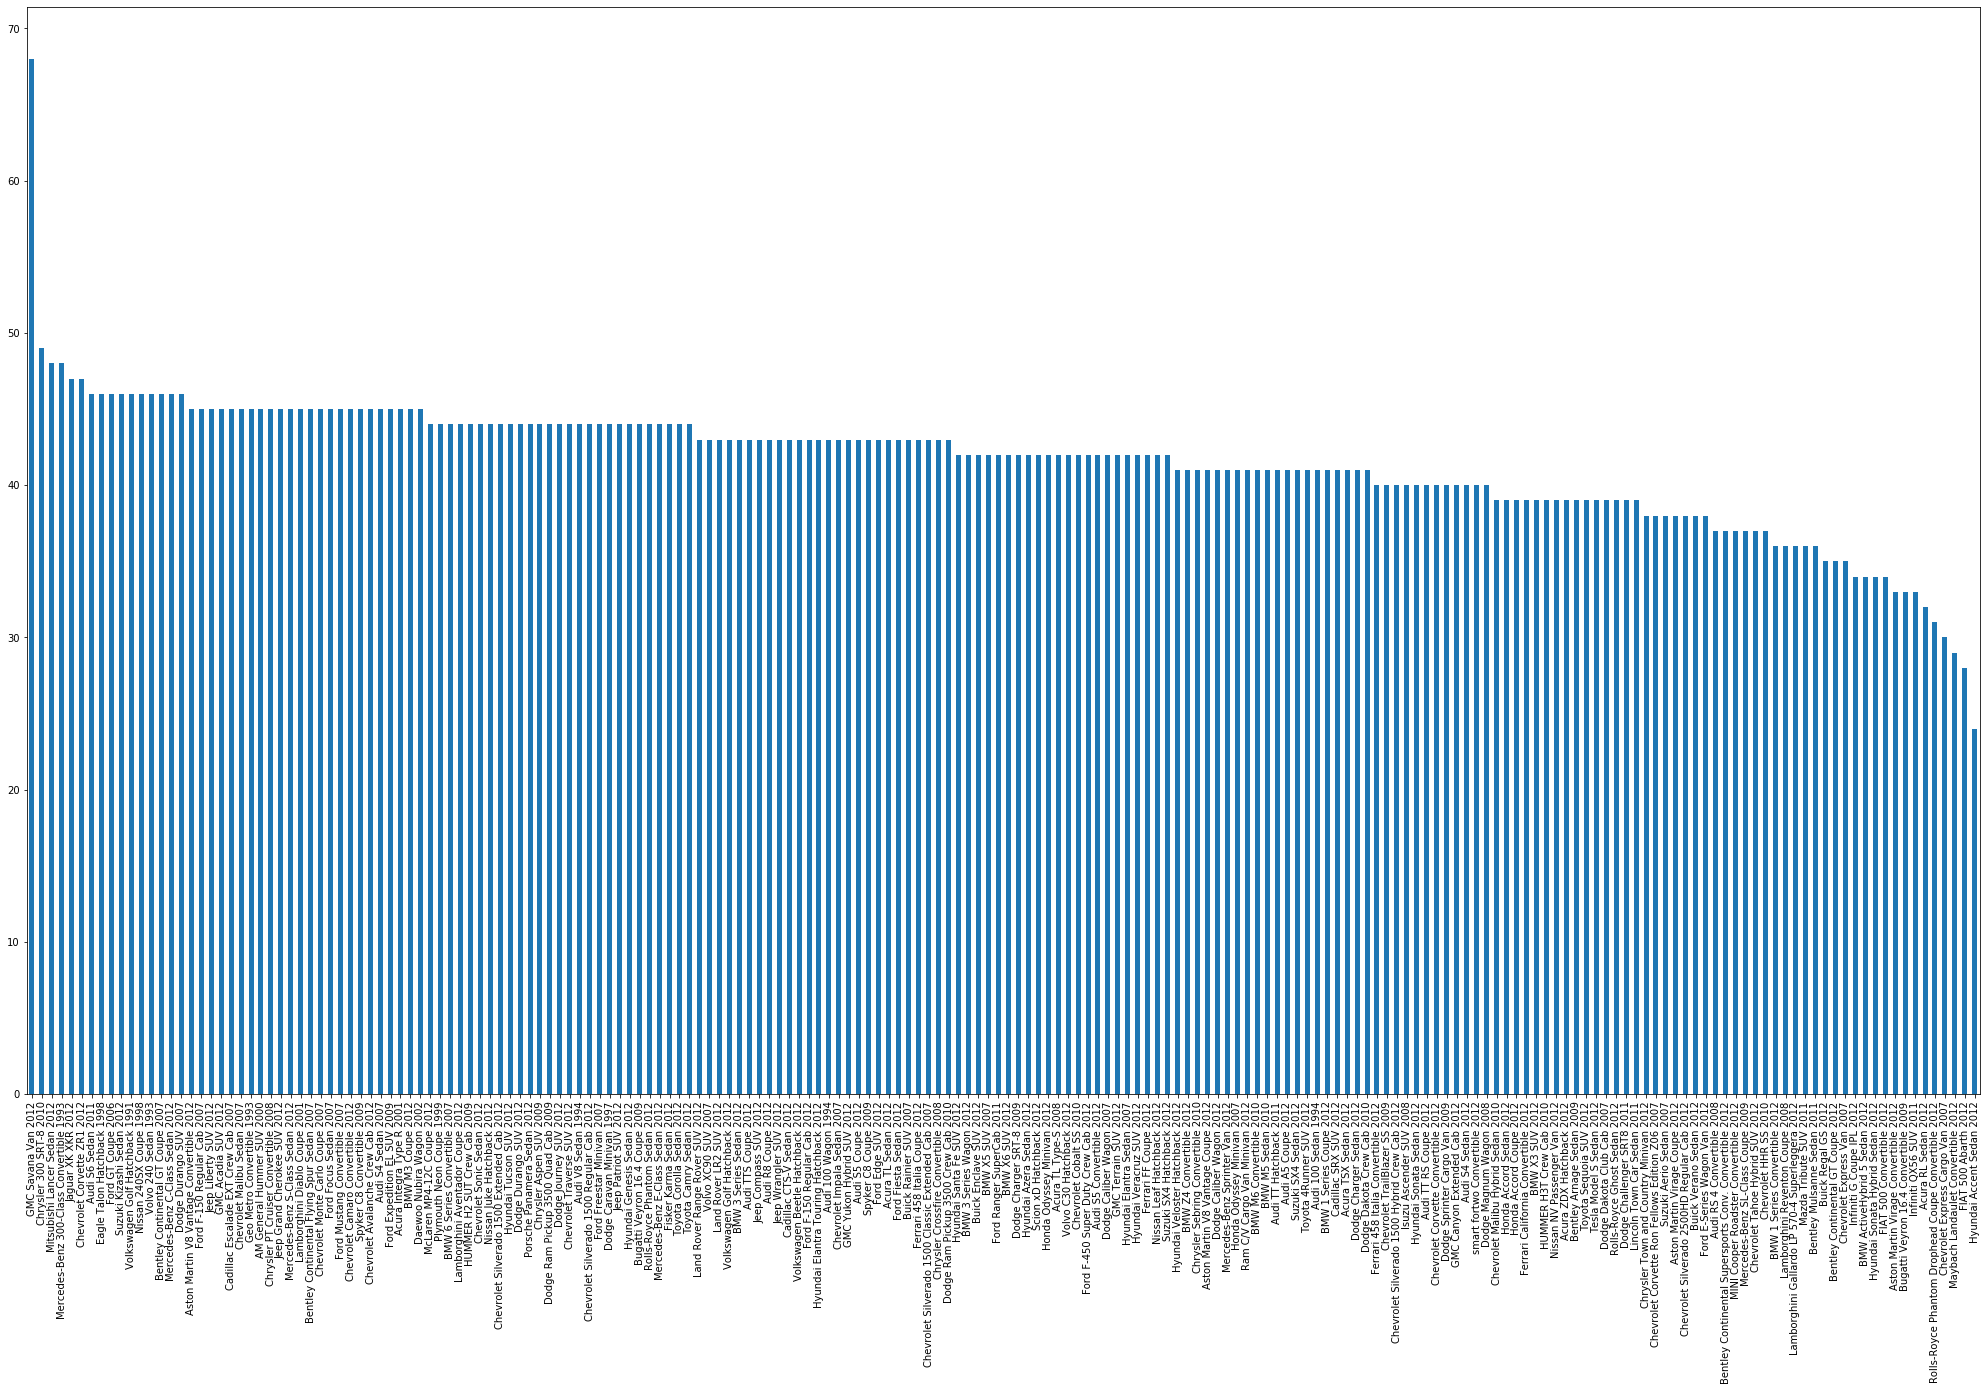

In [45]:
df_train['Models'].value_counts().plot(kind='bar', figsize=(35,20))

In [47]:
df['relative_im_path'][0]

"'car_ims/000001.jpg'"

In [10]:
def get_image_properties(df, i):
    image = Image.open(df['fpath'][i])
    title = df['Models'][i]
    
    xy = df['bbox_x1'][i], df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
    
    return (image, title, rect)

In [11]:
def display_image(df, i):
    image, title, rect = get_image_properties(df, i)
    print(title)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.gca().add_patch(rect)

AM General Hummer SUV 2000


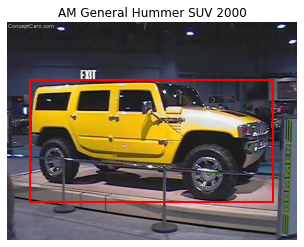

In [12]:
display_image(df_train, 20)

In [71]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from src.smallvggnet import SmallVGGNet
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [13]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


In [14]:
# grab the image paths and randomly shuffle them
imagePaths = df_train[['fpath', 'class']].sample(frac=1).reset_index(drop=True)

In [17]:
for index, row in imagePaths.iterrows():
    # load the image, resize it to 64x64 pixels (the required input
    # spatial dimensions of SmallVGGNet), and store the image in the
    # data list
    image = cv2.imread(row['fpath'])
    image = cv2.resize(image, (64, 64))
    data.append(image)
    
    # extract the class label from the image path and update the
    # labels list
    label = row['class']
    labels.append(label)

In [18]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [19]:
data

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [100]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, 
                                                  labels, test_size=0.25, random_state=680)

# convert the labels from integers to vectors (for 2-class, binary
# classification you should use Keras' to_categorical function
# instead as the scikit-learn's LabelBinarizer will not return a
# vector)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [101]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

# initialize our VGG-like Convolutional Neural Network
model = SmallVGGNet.build(width=64, height=64, depth=3,
    classes=len(lb.classes_))

In [102]:
# initialize our initial learning rate, # of epochs to train for,
# and batch size
INIT_LR = 0.01
EPOCHS = 75
BS = 32

# initialize the model and optimizer
print("[INFO] training network...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the network
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS)

[INFO] training network...
Epoch 1/75
190/190 [==============================] - 84s 443ms/step - loss: 6.4037 - accuracy: 0.0069 - val_loss: 5.5605 - val_accuracy: 0.0049
Epoch 2/75
190/190 [==============================] - 82s 430ms/step - loss: 6.0146 - accuracy: 0.0084 - val_loss: 5.4188 - val_accuracy: 0.0088
Epoch 3/75
190/190 [==============================] - 83s 436ms/step - loss: 5.8529 - accuracy: 0.0112 - val_loss: 5.3224 - val_accuracy: 0.0142
Epoch 4/75
190/190 [==============================] - 81s 428ms/step - loss: 5.7155 - accuracy: 0.0155 - val_loss: 5.2811 - val_accuracy: 0.0172
Epoch 5/75
190/190 [==============================] - 84s 441ms/step - loss: 5.6209 - accuracy: 0.0168 - val_loss: 5.2163 - val_accuracy: 0.0187
Epoch 6/75
 21/190 [==>...........................] - ETA: 1:10 - loss: 5.5704 - accuracy: 0.0149

KeyboardInterrupt: 

In [103]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'experimental_list_devices'

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
tf.test.is_built_with_cuda()

True

In [4]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9311787600331221381]

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
tf.test.is_built_with_cuda()

True

In [7]:
tf.test.is_gpu_available()

False